In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = pathlib.Path('images/')

Dataset from https://github.com/brian-the-dev/recaptcha-dataset

In [3]:
batch_size = 32
img_height = 120
img_width = 120


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 11774 files belonging to 12 classes.
Using 9420 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11774 files belonging to 12 classes.
Using 2354 files for validation.


In [6]:
class_names=train_ds.class_names
print(class_names)

['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney', 'Crosswalk', 'Hydrant', 'Motorcycle', 'Mountain', 'Other', 'Palm', 'Traffic Light']


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) 

0.0 0.9686275


In [9]:
num_classes = 12

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Softmax könnte in diesem Szenario problematisch sein, da mehrere der oben angeführten Klassen realistisch betrachtet auf dem gleichen Bild auftreten können (z.B. ein Auto auf einer Brücke oder ein Bild einer Kreuzung) . Ein Ansatz in dem die gesuchte Klasse auf einem Bild gesucht wird würde vermutlich besser funktionieren.

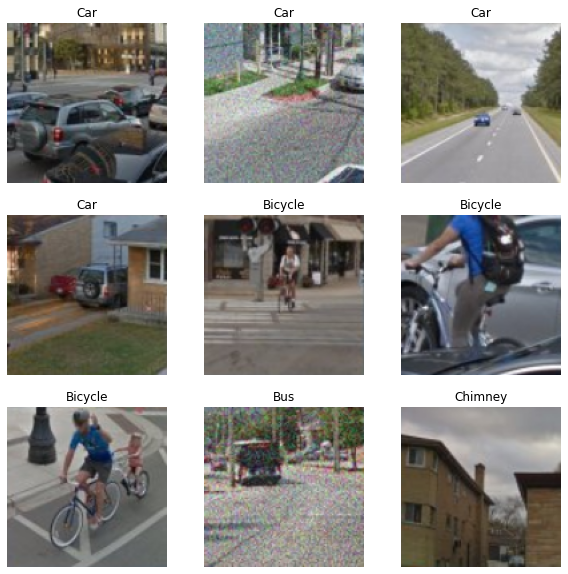

In [10]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 120, 120, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 120, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0

In [12]:
EPOCHS = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
)

Epoch 1/15
295/295 [==============================] - 48s 163ms/step - loss: 1.7387 - accuracy: 0.4080 - val_loss: 1.5417 - val_accuracy: 0.4511
Epoch 2/15
295/295 [==============================] - 43s 146ms/step - loss: 1.4040 - accuracy: 0.5084 - val_loss: 1.2850 - val_accuracy: 0.5493
Epoch 3/15
295/295 [==============================] - 43s 146ms/step - loss: 1.1738 - accuracy: 0.5881 - val_loss: 1.2192 - val_accuracy: 0.5731
Epoch 4/15
295/295 [==============================] - 43s 146ms/step - loss: 0.9906 - accuracy: 0.6495 - val_loss: 1.1753 - val_accuracy: 0.5960
Epoch 5/15
295/295 [==============================] - 43s 147ms/step - loss: 0.7942 - accuracy: 0.7231 - val_loss: 1.2255 - val_accuracy: 0.6015
Epoch 6/15
295/295 [==============================] - 44s 150ms/step - loss: 0.6121 - accuracy: 0.7864 - val_loss: 1.3950 - val_accuracy: 0.5879
Epoch 7/15
295/295 [==============================] - 44s 148ms/step - loss: 0.4226 - accuracy: 0.8556 - val_loss: 1.5853 - val_ac

Im obigen Training ist eine hohe Accuracy bei einer stagnierenden val_accuracy zu beobachten, ein overfitting-Szenario ist wahrscheinlich. Datenaugumentation scheint bei den verfügbaren Daten nur als begrenzt sinnvoll, dies wird später getestet. Versuch mit Dropout.

In [13]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 120, 120, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 120, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 64)       

In [15]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
)

Epoch 1/15
295/295 [==============================] - 46s 154ms/step - loss: 1.9789 - accuracy: 0.3265 - val_loss: 1.8452 - val_accuracy: 0.4082
Epoch 2/15
295/295 [==============================] - 45s 153ms/step - loss: 1.6688 - accuracy: 0.4117 - val_loss: 1.5724 - val_accuracy: 0.4376
Epoch 3/15
295/295 [==============================] - 45s 152ms/step - loss: 1.4858 - accuracy: 0.4747 - val_loss: 1.4608 - val_accuracy: 0.4907
Epoch 4/15
295/295 [==============================] - 45s 154ms/step - loss: 1.3343 - accuracy: 0.5232 - val_loss: 1.3632 - val_accuracy: 0.5387
Epoch 5/15
295/295 [==============================] - 45s 152ms/step - loss: 1.1876 - accuracy: 0.5760 - val_loss: 1.2429 - val_accuracy: 0.5688
Epoch 6/15
295/295 [==============================] - 45s 152ms/step - loss: 1.0521 - accuracy: 0.6247 - val_loss: 1.2093 - val_accuracy: 0.5956
Epoch 7/15
295/295 [==============================] - 45s 153ms/step - loss: 0.9483 - accuracy: 0.6684 - val_loss: 1.2093 - val_ac

Ergebnis ist etwas besser, allerdings ist der Unterschied zwischen accuracy und val_accuracy nach wie vor zu groß. Versuch mit Augumentierung.

In [16]:
augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [17]:
model = Sequential([
  augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 120, 120, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 120, 120, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 120, 120, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 32)       

In [19]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
295/295 [==============================] - 51s 169ms/step - loss: 1.8690 - accuracy: 0.3521 - val_loss: 1.6526 - val_accuracy: 0.4210
Epoch 2/15
295/295 [==============================] - 49s 168ms/step - loss: 1.5830 - accuracy: 0.4395 - val_loss: 1.5468 - val_accuracy: 0.4414
Epoch 3/15
295/295 [==============================] - 50s 169ms/step - loss: 1.4662 - accuracy: 0.4803 - val_loss: 1.4265 - val_accuracy: 0.4847
Epoch 4/15
295/295 [==============================] - 50s 168ms/step - loss: 1.3932 - accuracy: 0.5061 - val_loss: 1.3675 - val_accuracy: 0.5263
Epoch 5/15
295/295 [==============================] - 50s 168ms/step - loss: 1.3155 - accuracy: 0.5301 - val_loss: 1.2975 - val_accuracy: 0.5569
Epoch 6/15
295/295 [==============================] - 49s 167ms/step - loss: 1.2561 - accuracy: 0.5533 - val_loss: 1.2212 - val_accuracy: 0.5807
Epoch 7/15
295/295 [==============================] - 50s 170ms/step - loss: 1.2133 - accuracy: 0.5721 - val_loss: 1.1967 - val_ac

Accuracy und val_accuracy liegen nun nah beinander. In Kombination mit den oben genannten möglichen Problemen ist eine Präzision von 62% einigermaßen brauchbar, zumal es sich hier nicht um binäre Klassifizierung handelt sondern 12 Klassen verwendet werden. 

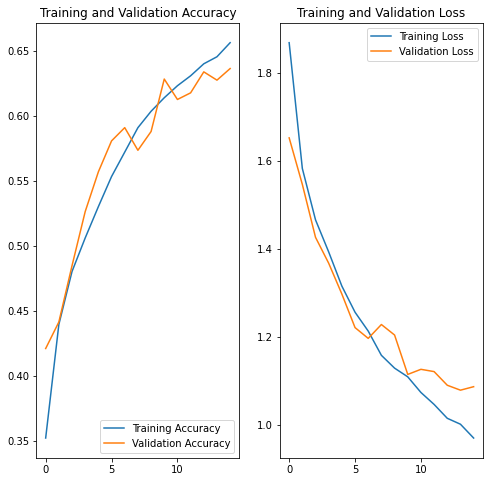

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Eine längere Trainingsdauer scheint nach dem obigen Diagram nicht als sinnvoll. Test des Models auf einem neuen Bild.

In [21]:
traffic_light = "https://www.toronto.ca/wp-content/uploads/2018/05/9074-Traffic-Signals-1024x338.jpg"
tlight = tf.keras.utils.get_file('Traffic_light2', origin=traffic_light)

img = tf.keras.utils.load_img(
    tlight, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)
print(
    "Image is {} at {:.2f} confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print(class_names)

73728/62427 [===================================] - 0s 1us/step
tf.Tensor(
[7.4375779e-03 1.3410468e-05 4.8909359e-02 1.9783091e-03 3.1558704e-11
 2.5367917e-06 1.2946838e-05 5.2325549e-07 1.1243004e-16 1.1259860e-02
 1.5916152e-05 9.3036956e-01], shape=(12,), dtype=float32)
Image is Traffic Light at 93.04 confidence.
['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney', 'Crosswalk', 'Hydrant', 'Motorcycle', 'Mountain', 'Other', 'Palm', 'Traffic Light']


Klassifizierung einer Ampel korrekt (in vorherigen Versuchen oft mit gelben Schulbus verwechselt). Versuch Zebrastreifen.

In [22]:
crossw_source = "https://upload.wikimedia.org/wikipedia/commons/0/05/Raised_crosswalk_1.jpg"
crosswalk = tf.keras.utils.get_file('crosswalk', origin=crossw_source)

img = tf.keras.utils.load_img(
    crosswalk, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)
print(
    "Image is {} at {:.2f} confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print(class_names)

204800/188546 [================================] - 0s 1us/step
tf.Tensor(
[4.2236269e-01 6.0797402e-06 9.7544804e-02 6.4043552e-02 9.0041914e-07
 1.7416266e-01 1.0442511e-05 7.5441846e-03 1.5288593e-12 1.8675996e-01
 8.5433589e-05 4.7479372e-02], shape=(12,), dtype=float32)
Image is Bicycle at 42.24 confidence.
['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney', 'Crosswalk', 'Hydrant', 'Motorcycle', 'Mountain', 'Other', 'Palm', 'Traffic Light']


Klassifizierung hier inkorrekt. Korrekte Lösung an 3.Stelle nach Klasse "Other". "Other" verursacht vermutlich einiges an Problemen im Model, da viele verschiedene Objekte/Features zu einer Klasse assoziert werden.